## Racial Bias in Recidivism Prediction
#### Kirstin Tretter

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline 
import seaborn as sns

pd.set_option('display.max_columns',500) #allows for up to 500 columns to be displayed when viewing a dataframe
#import pandas_profiling

#if you want graphs to automatically without plt.show
%matplotlib inline
plt.style.use('seaborn-v0_8')


### Import data
This data file contains recidivism information for violent offenders. Each offender was given a rating called a decile score that presumably assess their risk of reoffending in the next two years. The score is on a scale of 1-10 - with 1 being lowest and 10 being highest risk - and is broken into Low, Medium, and High risk categories. The is_recid column tells whether the person reoffended or not (0 for no and 1 for yes). The is_recid column is coded -1 if the original researchers were not able to determine one way or the other. (can add citation)

In [2]:
df_recid = pd.read_csv('data/cox-violent-parsed_filt.csv')

In [3]:
df_recid.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18316 entries, 0 to 18315
Data columns (total 40 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       11001 non-null  float64
 1   name                     18316 non-null  object 
 2   first                    18316 non-null  object 
 3   last                     18316 non-null  object 
 4   sex                      18316 non-null  object 
 5   dob                      18316 non-null  object 
 6   age                      18316 non-null  int64  
 7   age_cat                  18316 non-null  object 
 8   race                     18316 non-null  object 
 9   juv_fel_count            18316 non-null  int64  
 10  decile_score             18316 non-null  int64  
 11  juv_misd_count           18316 non-null  int64  
 12  juv_other_count          18316 non-null  int64  
 13  priors_count             18316 non-null  int64  
 14  days_b_screening_arres

In [4]:
# research into the data set says that when is_recid = -1, the researcher was not able to determine either way, so those have
# been removed from the analysis

df_recid_clean = df_recid[df_recid['is_recid'] != -1].copy()
df_recid_clean = df_recid_clean[df_recid_clean['decile_score'] != -1]

In [5]:
df_recid_clean['decile_score'].value_counts()

decile_score
1     2718
2     1928
4     1754
3     1719
7     1673
6     1642
9     1622
5     1579
8     1557
10    1287
Name: count, dtype: int64

In [6]:
df_recid['decile_score'].value_counts()

decile_score
 1     2923
 2     2031
 4     1830
 3     1813
 7     1720
 6     1713
 9     1670
 5     1649
 8     1614
 10    1330
-1       23
Name: count, dtype: int64

### Visualization

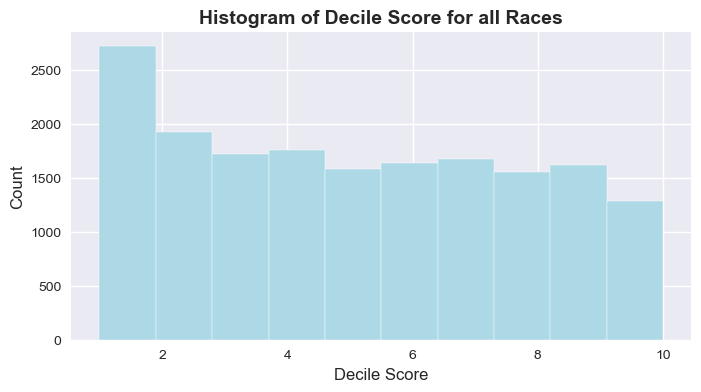

In [7]:
plt.figure(figsize=(8, 4))
df_recid_clean['decile_score'].plot(kind='hist', color='lightblue', edgecolor='white')
plt.xlabel('Decile Score', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.title('Histogram of Decile Score for all Races', fontweight='bold', fontsize='14', horizontalalignment='center')
plt.show()

In this histogram of scores for all races combined, we can see that distribution is skewed with more scores on the lower end "low risk" category.

                            Histogram of Decile Scores for Caucasian and African-American Inmates


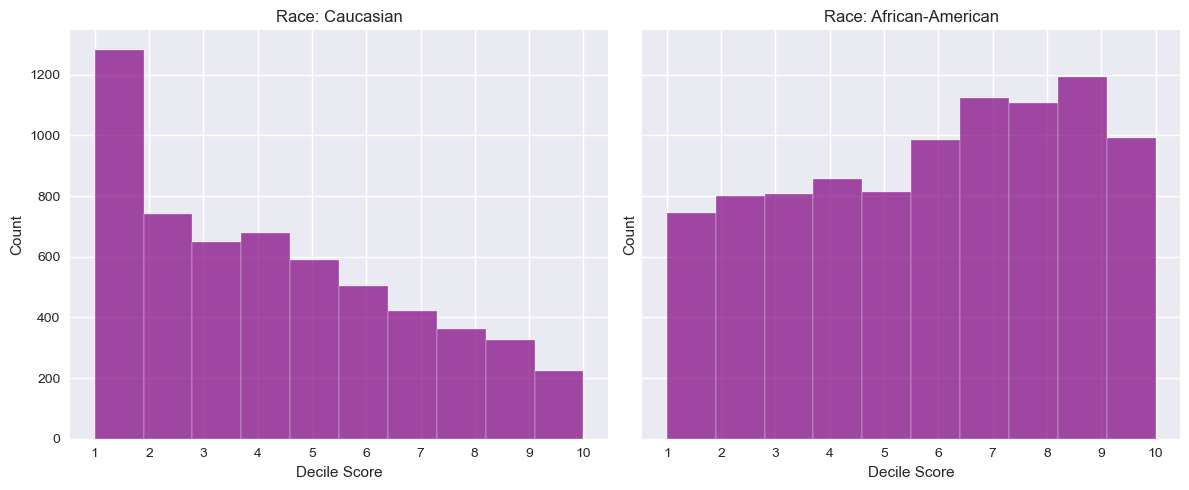

In [8]:
# Define races to plot - code written with the assistance of ChatGPT
races_to_plot = ["Caucasian", "African-American"]

fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharex=True, sharey=True)

for ax, race in zip(axes, races_to_plot):
    subset = df_recid_clean[df_recid_clean["race"] == race]
    ax.hist(subset["decile_score"], bins=10, color="purple", alpha=0.7, edgecolor='white')
    ax.set_xticks(range(df_recid_clean["decile_score"].min(), df_recid_clean["decile_score"].max()+1))  # Ensure x-axis ticks align
    ax.set_title(f"Race: {race}")
    ax.set_xlabel("Decile Score")
    ax.set_ylabel("Count")

print('                            Histogram of Decile Scores for Caucasian and African-American Inmates')
plt.tight_layout()
plt.show()

These figures show the scores for only white offenders on the left and only black offenders on the left. Unlike the previous figure with all offenders combined, we can clearly see that there is racial disparity and the distribution of scores are different depending on the race of the inmate. White offenders were much more likely to be given a score in the low-meduim risk range, while black offenders were more likely to be given a score in the high risk range.

### Calculating the rate of false positives
A false positive will be defined as someone whose recidivism score was "High" but did not reoffend. 

In [9]:
false_positives = df_recid[(df_recid['score_text'] == 'High') & (df_recid['is_recid'] == 0)]

In [10]:
# Total predictions by race
total_predictions_by_race = df_recid['race'].value_counts()


In [11]:
# Count false positives by race
fp_race_counts = false_positives['race'].value_counts()


In [12]:
# Calculate false positive rate by race
fp_rate_by_race = (fp_race_counts / total_predictions_by_race) * 100

fp_rate_by_race

race
African-American    11.377796
Caucasian            5.422281
Hispanic             5.720193
Other                1.627907
Asian                4.225352
Native American      1.754386
Name: count, dtype: float64

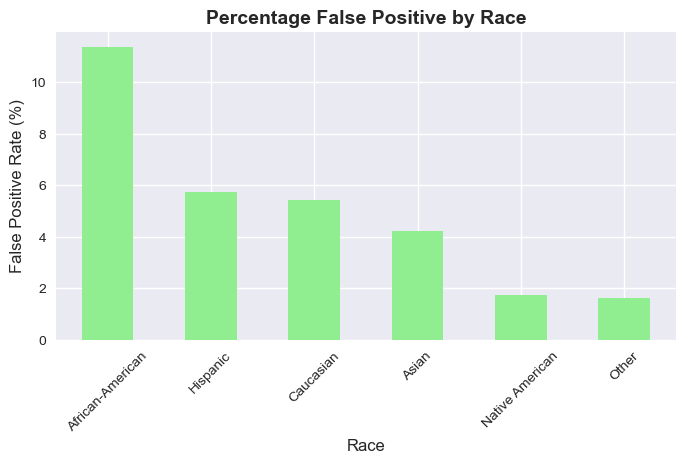

In [13]:
plt.figure(figsize=(8, 4))
fp_rate_by_race.sort_values(ascending=False).plot(kind='bar', color='lightgreen')
plt.xlabel('Race', fontsize=12)
plt.ylabel('False Positive Rate (%)', fontsize=12)
plt.xticks(rotation=45)
plt.title('Percentage False Positive by Race', fontweight='bold', fontsize='14', horizontalalignment='center')
plt.show()

By calculating the false positive rate, we can confirm that there is racial bias in the data set when it is used to predict an offender's risk of recidivism. Black offenders were incorrectly predicted to reoffend at a rate twice that of any other race - nearly 12%.

In [15]:
false_negatives = df_recid[(df_recid['score_text'] == 'Low') & (df_recid['is_recid'] == 1)]

In [16]:
# Total predictions by race
total_predictions_by_race = df_recid['race'].value_counts()

In [17]:
# Count false positives by race
fn_race_counts = false_negatives['race'].value_counts()

In [18]:
# Calculate false negative rate by race
fn_rate_by_race = (fn_race_counts / total_predictions_by_race) * 100

fn_rate_by_race

race
African-American    12.848534
Caucasian           17.630628
Hispanic            16.333563
Other               25.000000
Asian                9.859155
Native American      3.508772
Name: count, dtype: float64

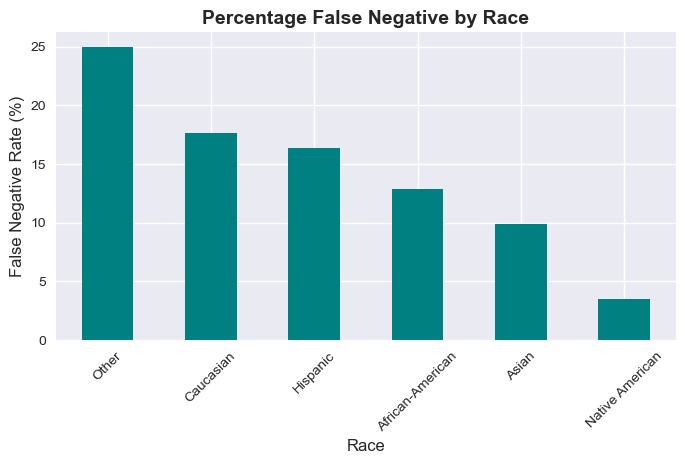

In [21]:
plt.figure(figsize=(8, 4))
fn_rate_by_race.sort_values(ascending=False).plot(kind='bar', color='teal')
plt.xlabel('Race', fontsize=12)
plt.ylabel('False Negative Rate (%)', fontsize=12)
plt.xticks(rotation=45)
plt.title('Percentage False Negative by Race', fontweight='bold', fontsize='14', horizontalalignment='center')
plt.show()